## Machine Learning Models!

#### Goals: My aim is to predict Swell Height from this time series dataset.
#### I'll be using 1.5 years of data and rest half a year for testing. (1/1/20-1/6/21 --> training, 2/6/21-31/12/21 --> testing)

#### In order to evaluate how good the model is, I would be using R^2 and RMSE


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import os
from collections import Counter
%matplotlib inline

import sklearn
from sklearn import svm
from sklearn.svm import SVR
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import TimeSeriesSplit,cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('./for_MLtest.csv')
del df["Unnamed: 0"]
df

,date,swell_rating,primary_swell_height,primary_swell_period
0,2020-01-01 02:00:00,1,1.0,8
1,2020-01-01 05:00:00,0,1.0,7
2,2020-01-01 08:00:00,1,0.9,7
3,2020-01-01 11:00:00,1,0.8,7
4,2020-01-01 14:00:00,0,0.8,7
...,...,...,...,...
9855,2021-12-30 15:00:00,1,0.7,8
9856,2021-12-30 21:00:00,0,0.9,7
9857,2021-12-31 09:00:00,1,1.1,7
9858,2021-12-31 15:00:00,1,0.9,8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9860 entries, 0 to 9859
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  9860 non-null   object 
 1   swell_rating          9860 non-null   int64  
 2   primary_swell_height  9860 non-null   float64
 3   primary_swell_period  9860 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 308.2+ KB


In [4]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()


In [5]:
df['date'] = pd.DatetimeIndex(df['date'])
df = df.set_index('date')
df

,swell_rating,primary_swell_height,primary_swell_period
date,,,
2020-01-01 02:00:00,1,1.0,8
2020-01-01 05:00:00,0,1.0,7
2020-01-01 08:00:00,1,0.9,7
2020-01-01 11:00:00,1,0.8,7
2020-01-01 14:00:00,0,0.8,7
...,...,...,...
2021-12-30 15:00:00,1,0.7,8
2021-12-30 21:00:00,0,0.9,7
2021-12-31 09:00:00,1,1.1,7


#### In order to print all performace metrics that relevant to a regression task there's the following regression_results function.

In [6]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Feature Engineering
#### I choose a simplistic model, one that predicts today's swell height value based on:
##### * yesterday's swell height value
##### * difference between yesterday and the day before yesterday's swell height value

In [7]:
data_SH = df[['primary_swell_height']]

data_SH.loc[:,'Yesterday'] = data_SH.loc[:,'primary_swell_height'].shift()


data_SH.loc[:,'Yesterday_Diff'] = data_SH.loc[:,'Yesterday'].diff()

data_SH = data_SH.dropna()

In [8]:
data_SH


,primary_swell_height,Yesterday,Yesterday_Diff
date,,,
2020-01-01 08:00:00,0.9,1.0,0.0
2020-01-01 11:00:00,0.8,0.9,-0.1
2020-01-01 14:00:00,0.8,0.8,-0.1
2020-01-01 17:00:00,0.7,0.8,0.0
2020-01-01 20:00:00,0.7,0.7,-0.1
...,...,...,...
2021-12-30 15:00:00,0.7,0.3,-0.2
2021-12-30 21:00:00,0.9,0.7,0.4
2021-12-31 09:00:00,1.1,0.9,0.2


### Defining training and test sets

In [9]:
X_train = data_SH.loc[:'2021-06-01'].drop(['primary_swell_height'], axis = 1)
y_train = data_SH.loc[:'2021-06-01', 'primary_swell_height']
X_test = data_SH.loc['2021-06-02':'2021-12-31 00:00:00'].drop(['primary_swell_height'], axis = 1)
y_test = data_SH.loc['2021-06-02':'2021-12-31 00:00:00', 'primary_swell_height']

### Check Algorithms

In [10]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

LR: 0.850122 (0.056061)


C:\Users\Assaf\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Assaf\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Assaf\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

NN: 0.852892 (0.053659)
KNN: 0.812036 (0.066824)
RF: 0.834902 (0.055180)
SVR: 0.855298 (0.052778)


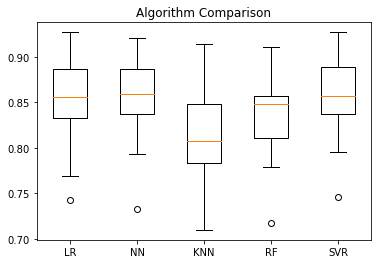

In [11]:
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

### Defining custom scorer by setting scoring = rmse_score, define custom scorer as:

In [12]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

### Grid Searching Hyperparameters
#### An optimal combination of hyperparameters maximizes a model's performance without leading to overfitting.

In [13]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

### Checking best model performance on test data

In [14]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8762
mean_squared_log_error:  0.0084
r2:  0.8762
MAE:  0.1
MSE:  0.031
RMSE:  0.176


### Now lets also use values from (today - 2) to predict Swell Height:

In [15]:
# creating copy of original dataframe
data_SH_2o = data_SH.copy()
# inserting column with yesterday-1 values
data_SH_2o['Yesterday-1'] = data_SH_2o['Yesterday'].shift()
# inserting column with difference in yesterday-1 and yesterday-2 values.
data_SH_2o['Yesterday-1_Diff'] = data_SH_2o['Yesterday-1'].diff()
# dropping NAs
data_SH_2o = data_SH_2o.dropna()

In [16]:
data_SH_2o

,primary_swell_height,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
date,,,,,
2020-01-01 14:00:00,0.8,0.8,-0.1,0.9,-0.1
2020-01-01 17:00:00,0.7,0.8,0.0,0.8,-0.1
2020-01-01 20:00:00,0.7,0.7,-0.1,0.8,0.0
2020-01-01 23:00:00,0.7,0.7,0.0,0.7,-0.1
2020-01-02 02:00:00,0.7,0.7,0.0,0.7,0.0
...,...,...,...,...,...
2021-12-30 15:00:00,0.7,0.3,-0.2,0.5,0.0
2021-12-30 21:00:00,0.9,0.7,0.4,0.3,-0.2
2021-12-31 09:00:00,1.1,0.9,0.2,0.7,0.4


### Updating the train and test sets

In [17]:
X_train_2o = data_SH.loc[:'2021-06-01'].drop(['primary_swell_height'], axis = 1)
y_train_2o = data_SH.loc[:'2021-06-01', 'primary_swell_height']
X_test = data_SH.loc['2021-06-02':'2021-12-31 00:00:00'].drop(['primary_swell_height'], axis = 1)
y_test = data_SH.loc['2021-06-02':'2021-12-31 00:00:00', 'primary_swell_height']

### Lets see if we can perform better according to our new predictors

In [18]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o, y_train_2o)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8751
mean_squared_log_error:  0.0084
r2:  0.8751
MAE:  0.1009
MSE:  0.0313
RMSE:  0.1768


### We can definetly see that the R^2 value has gone up

### Now lets see if adding another value like Swell Period would be beneficial

In [19]:
data_SH_2o_SP = data_SH_2o.join(df[['primary_swell_period']])
data_SH_2o_SP = data_SH_2o_SP.dropna()

In [20]:
data_SH_2o_SP

,primary_swell_height,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,primary_swell_period
date,,,,,,
2020-01-01 00:00:00,1.1,2.2,-0.1,2.3,-0.2,8
2020-01-01 00:00:00,1.1,2.2,-0.1,2.3,-0.2,8
2020-01-01 00:00:00,0.9,2.3,-0.2,2.5,-0.1,8
2020-01-01 00:00:00,0.9,2.3,-0.2,2.5,-0.1,8
2020-01-01 03:00:00,1.0,1.1,-1.1,2.2,-0.1,7
...,...,...,...,...,...,...
2021-12-31 18:00:00,0.8,1.0,0.0,1.0,0.1,8
2021-12-31 18:00:00,0.8,1.0,0.0,1.0,0.1,8
2021-12-31 18:00:00,0.9,0.9,-0.2,1.1,0.2,8


### And again, we repeat the steps. Updating train, test sets + Checkinig performance

In [21]:
X_train_2o_SP = data_SH_2o_SP.loc[:'2021-06-01'].drop(['primary_swell_height'], axis = 1)
y_train_2o_SP = data_SH_2o_SP.loc[:'2021-06-01', 'primary_swell_height']
X_test = data_SH_2o_SP.loc['2021-06-02':'2021-12-31 00:00:00'].drop(['primary_swell_height'], axis = 1)
y_test = data_SH_2o_SP.loc['2021-06-02':'2021-12-31 00:00:00', 'primary_swell_height']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_SP, y_train_2o_SP)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8613
mean_squared_log_error:  0.0103
r2:  0.8613
MAE:  0.1188
MSE:  0.0388
RMSE:  0.197


### This time, our R^2 has been dropped a little.
#### Lets see a variable importance plot

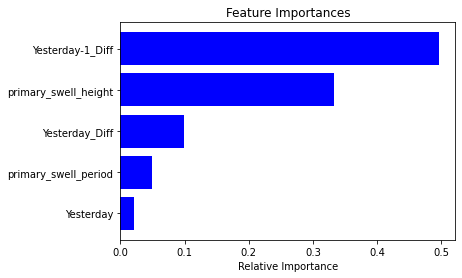

In [22]:
imp = best_model.feature_importances_
features = data_SH_2o_SP.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices -2])
plt.xlabel('Relative Importance')
plt.show()

### Now as we already know how to check the time series, let's check the Swell Height in the week prior to the given date.

In [23]:
data_SH_2o_SP_weeklyShift = data_SH_2o_SP.copy()
data_SH_2o_SP_weeklyShift['Last_Week'] = data_SH_2o_SP['primary_swell_height'].shift(7)
data_SH_2o_SP_weeklyShift = data_SH_2o_SP_weeklyShift.dropna()

In [24]:
data_SH_2o_SP_weeklyShift

,primary_swell_height,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,primary_swell_period,Last_Week
date,,,,,,,
2020-01-01 03:00:00,0.9,0.9,-1.4,2.3,-0.2,7,1.1
2020-01-01 06:00:00,0.9,1.0,-0.1,1.1,-1.1,7,1.1
2020-01-01 06:00:00,0.9,1.0,-0.1,1.1,-1.1,7,0.9
2020-01-01 06:00:00,0.8,0.9,0.0,0.9,-1.4,7,0.9
2020-01-01 06:00:00,0.8,0.9,0.0,0.9,-1.4,7,1.0
...,...,...,...,...,...,...,...
2021-12-31 18:00:00,0.8,1.0,0.0,1.0,0.1,8,1.1
2021-12-31 18:00:00,0.8,1.0,0.0,1.0,0.1,8,1.1
2021-12-31 18:00:00,0.9,0.9,-0.2,1.1,0.2,8,1.0


### And again, we repeat the steps. Updating train, test sets + Checkinig performance

In [25]:
X_train_2o_SP_weeklyShift = data_SH_2o_SP_weeklyShift.loc[:'2021-06-01'].drop(['primary_swell_height'], axis = 1)
y_train_2o_SP_weeklyShift = data_SH_2o_SP_weeklyShift.loc[:'2021-06-01', 'primary_swell_height']
X_test = data_SH_2o_SP_weeklyShift.loc['2021-06-02':'2021-12-31 00:00:00'].drop(['primary_swell_height'], axis = 1)
y_test = data_SH_2o_SP_weeklyShift.loc['2021-06-02':'2021-12-31 00:00:00', 'primary_swell_height']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_SP_weeklyShift, y_train_2o_SP_weeklyShift)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8883
mean_squared_log_error:  0.0086
r2:  0.8883
MAE:  0.1114
MSE:  0.0313
RMSE:  0.1768


### Now our R^2 has gone way up! it's 88.83% and our RMSE has gone down!

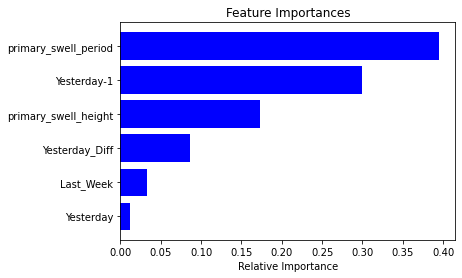

In [26]:
imp = best_model.feature_importances_
features = data_SH_2o_SP_weeklyShift.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices -2])
plt.xlabel('Relative Importance')
plt.show()